# **ANN**

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
from scipy import stats
import pandas as pd



#### Load data

In [2]:
filename = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(filename)
raw_data = df.values

cols = range(0, 12)

X = raw_data[:, cols]

attributeNames = np.asarray(df.columns[cols])
attribute_dic = dict(zip(attributeNames, range(len(attributeNames))))

# Our class labels is DEATH 
classLabels = raw_data[:, -1]
classNames = sorted(set(classLabels))
classDic = dict(zip(classNames, range(len(classNames))))
y = np.array([classDic[i] for i in classLabels])
y = y.reshape(299,1)
N, M = X.shape
C = len(classNames)

Training model of type:

Sequential(
  (0): Linear(in_features=12, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/5

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.3850999	0.00034951928
		2000	0.32745782	5.8516765e-05
		3000	0.30573854	5.6045847e-05
		4000	0.29488593	2.7387567e-05
		5000	0.28691444	2.6071146e-05
		6000	0.28015366	2.2126236e-05
		7000	0.27393693	2.2628357e-05
		8000	0.26860574	1.7086304e-05
		9000	0.26458538	1.3178453e-05
		10000	0.26153132	1.025568e-05
		Final loss:
		10000	0.26153132	1.025568e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.37685362	0.00030563743
		2000	0.3078416	9.8640245e-05
		3000	0.2917597	2.6455324e-05
		4000	0.28329787	5.8591762e-05
		5000	0.2675667	5.3906355e-05
		6000	0.2584094	2.5256602e-05
		7000	0.25296533	1.8378316e-05
		8000	0.24866675	1.5280442e-05
		9000	0.24491218	1.4967123e-05
		10000	0.24163835	1.1716631e-05
		Final loss:
		10000	0.2

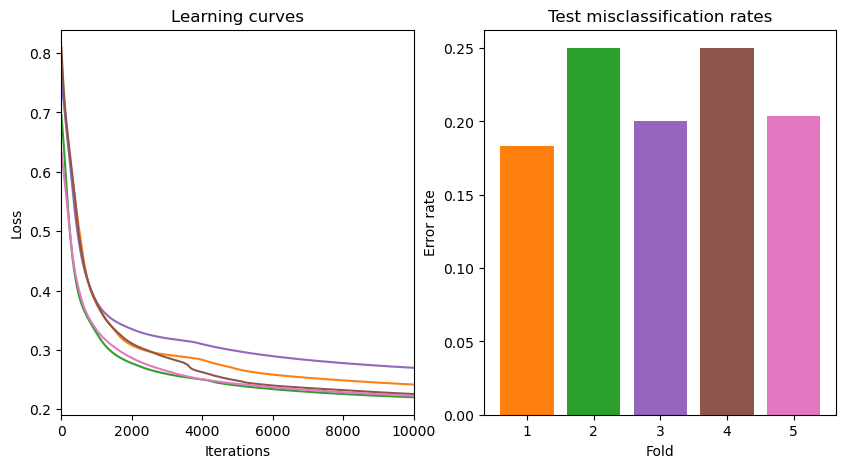

In [3]:
# Normalize data
X = stats.zscore(X);

# Parameters for neural network classifier
n_hidden_units = 2     # number of hidden units
n_replicates = 2        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 5                   # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model, see also Exercise 8.2.2-script for more information.
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = (y_sigmoid>.5).type(dtype=torch.uint8)

    # Determine errors and errors
    y_test = y_test.type(dtype=torch.uint8)

    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')

print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
# draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))